# Bayesian GMM Comparison: Coupled vs. Decoupled Inference

This notebook compares two Variational Bayesian approaches to Gaussian Mixture Models (GMM):

1.  **Coupled Inference (Exact/Conjugate)**: 
    *   Uses a **Normal-Inverse-Wishart (NIW)** joint prior $p(\mu, \Lambda) = p(\mu|\Lambda)p(\Lambda)$.
    *   The posterior $q(\mu, \Lambda)$ factorizes similarly, preserving the coupling between the uncertainty in the mean and the precision.

2.  **Decoupled Inference (Mean-Field)**:
    *   Uses independent priors $p(\mu, \Lambda) = p(\mu)p(\Lambda)$.
    *   The approximate posterior is factorized as $q(\mu, \Lambda) = q(\mu)q(\Lambda)$.

**Evaluation Protocol:**
We generate synthetic data, split it into **Train** and **Test** sets. We train both models on the training set to obtain a posterior. Then, we use this training posterior as the **prior** for the test set and run variational inference on the test set to maximize the ELBO. This Test ELBO serves as a lower bound on the marginal log-likelihood of the test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, special, linalg
from matplotlib.patches import Ellipse
import matplotlib as mpl

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score

np.random.seed(101)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Data Generation

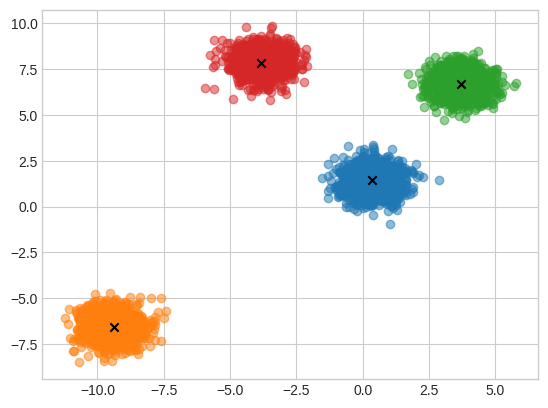

In [2]:
def initialize_params(X, n_components=4):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = BayesianGaussianMixture(
        n_components=n_components, init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', tol=1e-9, max_iter=0
    ).fit(X)
    nu = gmm.degrees_of_freedom_
    cov = gmm.covariances_
    return gmm.means_, gmm.mean_precision_, cov, np.linalg.inv(cov) / nu[..., None, None], nu, gmm.weight_concentration_

n_comps = 4
X, z_true = make_blobs(n_samples=4000, centers=n_comps, cluster_std=0.60)

means, *_ = initialize_params(X)
for i in range(4):
    data = X[z_true == i]
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)

for i in range(4):
    plt.scatter(means[i, 0], means[i, 1], color='black', marker='x')

## 2. Helper Functions

In [3]:
def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Plot a confidence ellipse of a 2D Gaussian.
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = mpl.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def compute_ari(z_true, r_pred):
    # Hard assignment
    z_pred = np.argmax(r_pred, axis=1)
    return adjusted_rand_score(z_true, z_pred)

## 3. Method 1: Coupled Bayesian GMM (NIW)

**Prior**:
$$ p(\mu, \Lambda) = \mathcal{N}(\mu | m_0, (\beta_0 \Lambda)^{-1}) \mathcal{W}(\Lambda | W_0, \nu_0) $$

**Posterior Update**:
Standard conjugate updates for $m_k, \beta_k, W_k, \nu_k$.

In [4]:
class CoupledBayesianGMM:
    def __init__(self, K):        
        # Default Hyperprior (NIW)
        self.bgmm = BayesianGaussianMixture(
                n_components=K, 
                init_params='kmeans', 
                weight_concentration_prior_type='dirichlet_distribution',
                warm_start=True
            )

    def fit(self, X, max_iter=100):
        elbo_history = []
        self.bgmm.max_iter = max_iter
        res = self.bgmm.fit(X)

        self.elbo_history = res.lower_bounds_
        self.r = self.bgmm.predict_proba(X)
        return self.elbo_history

## 4. Method 2: Decoupled Bayesian GMM (Mean-Field)

**Prior**:
$$ p(\mu) = \mathcal{N}(\mu | m_0, \Sigma_{0, \mu}) $$
$$ p(\Lambda) = \mathcal{W}(\Lambda | W_0, \nu_0) $$
(Note: Independent! The prior on $\mu$ does not depend on $\Lambda$)

**Posterior Approximation**:
$$ q(\mu) = \mathcal{N}(m_k, V_k) $$
$$ q(\Lambda) = \mathcal{W}(W_k, \nu_k) $$

**Key Difference in Updates**:
The update for $q(\Lambda)$ involves $\mathbb{E}[(x-\mu)(x-\mu)^T]$. 
Since $\mu$ and $\Lambda$ are independent in $q$:
$$ \mathbb{E}_{q(\mu)} [(x-\mu)(x-\mu)^T] = (x - \mathbb{E}[\mu])(x - \mathbb{E}[\mu])^T + \text{Cov}(\mu) $$
The $\text{Cov}(\mu) = V_k$ term is the extra variance that flows into the noise estimate but is "decoupled" from the mean's distribution definition.

In [5]:
class DecoupledBayesianGMM:
    def __init__(self, K, D, prior_params=None):
        self.K = K
        self.D = D
        
        self.m0 = np.zeros(D)
        self.P0 = np.eye(D)
        self.W0 = np.eye(D)
        self.nu0 = D + 2.0
        self.alpha0 = 1.0 / K
            
        # Initialize q(mu) params
        self.m = np.array([self.m0 for _ in range(K)])
        self.V = np.array([np.linalg.inv(self.P0) for _ in range(K)]) # Covariance of mu
        
        # Initialize q(Lambda) params
        self.W = np.array([self.W0 for _ in range(K)])
        self.nu = np.ones(K) * self.nu0
        
        self.alpha = np.ones(K) * self.alpha0

    def _multidigamma(self, nu):
        return special.digamma(nu[..., None] - 0.5 * np.arange(self.D)).sum(-1)

    def _log_wishart_expectations(self, W, nu):
        D = self.D
        log_det_W = np.linalg.slogdet(W)[1]
        E_log_det_Lambda = D * np.log(2) + log_det_W
        return E_log_det_Lambda + self._multidigamma(nu / 2)

    def e_step(self, X):
        N = X.shape[0]
        log_rho = np.zeros((N, self.K))
        
        E_log_pi = special.digamma(self.alpha) - special.digamma(np.sum(self.alpha))
        
        for k in range(self.K):
            E_Lambda_k = self.nu[k] * self.W[k]
            E_log_det_L = self._log_wishart_expectations(self.W[k], self.nu[k])
            
            # E[(x - mu)^T Lambda (x - mu)]
            # = E[ Tr( (x-mu)(x-mu)^T Lambda ) ]
            # Since mu indep Lambda:
            # = Tr( E[(x-mu)(x-mu)^T] E[Lambda] )
            # E[(x-mu)(x-mu)^T] = (x-m)(x-m)^T + V
            diff = X - self.m[k]
            # Term 1: (x-m)^T E[L] (x-m)
            mahal = np.sum((diff @ E_Lambda_k) * diff, axis=1)
            # Term 2: Tr(V * E[L])
            trace_term = np.trace(self.V[k] @ E_Lambda_k)
            
            quad_term = mahal + trace_term
            
            log_rho[:, k] = E_log_pi[k] + 0.5 * E_log_det_L - 0.5 * self.D * np.log(2 * np.pi) - 0.5 * quad_term

        log_norm = special.logsumexp(log_rho, axis=1, keepdims=True)
        r = np.exp(log_rho - log_norm)
        return r, log_norm.sum()

    def m_step(self, X, r):
        N_k = np.sum(r, axis=0) + 1e-10
        x_bar = (r.T @ X) / N_k[:, None]
        
        self.alpha = self.alpha0 + N_k

        # Priors
        p_P0, p_m0 = self.P0, self.m0
        p_W0 = self.W0
        
        for k in range(self.K):            
            E_Lambda = self.nu[k] * self.W[k]
            
            # --- Update q(mu) ---
            # Precision = P0 + N_k * E[Lambda]
            new_P = p_P0 + N_k[k] * E_Lambda
            new_V = np.linalg.inv(new_P)
            self.V[k] = new_V
            
            # Mean = V @ (P0 m0 + E[Lambda] sum(r x))
            weighted_sum_x = N_k[k] * x_bar[k]
            term1 = p_P0 @ p_m0
            term2 = E_Lambda @ weighted_sum_x
            self.m[k] = linalg.solve(new_P, (term1 + term2), assume_a='pos')

            # W^-1 = W0^-1 + sum r_nk E[(x-mu)(x-mu)^T]
            # E[...] = (x - m)(x - m)^T + V
            
            # Scatter of data about current mean m
            diff_x = X - self.m[k]
            S_k = (diff_x.T * r[:, k]) @ diff_x
            
            # Add trace term: sum r_nk * V = N_k * V
            V_term = N_k[k] * self.V[k]
            
            # W0^-1( I + W0 (S_k + V_term))
            self.W[k] = linalg.solve(np.eye(self.D) + p_W0 @ (S_k + V_term), p_W0)
            self.nu[k] = self.nu0 + N_k[k]

    def compute_elbo(self, log_norm):

        ll_term = log_norm

        # Dirichlet KL
        curr_alpha0 = np.ones(self.K)*self.alpha0
        kl_theta = special.gammaln(np.sum(self.alpha)) - special.gammaln(np.sum(curr_alpha0)) - np.sum(special.gammaln(self.alpha)) + np.sum(special.gammaln(curr_alpha0))
        kl_theta += np.sum((self.alpha - curr_alpha0) * (special.digamma(self.alpha) - special.digamma(np.sum(self.alpha))))

        for k in range(self.K):
            p_P0, p_m0 = self.P0, self.m0
            p_W0, p_nu0 = self.W0, self.nu0
                
            # KL(q(mu) || p(mu))
            # Normal-Normal
            # 0.5 * ( tr(P0 V) + (m - m0)T P0 (m - m0) - D - log|V| + log|P0^-1| )
            diff = self.m[k] - p_m0
            term_tr = np.trace(p_P0 @ self.V[k])
            term_quad = diff @ p_P0 @ diff
            sign, log_det_V = np.linalg.slogdet(self.V[k])
            sign, log_det_invP0 = np.linalg.slogdet(np.linalg.inv(p_P0))
            
            kl_theta += 0.5 * (term_tr + term_quad - self.D - log_det_V + log_det_invP0)

            
            # KL(q(Lambda) || p(Lambda))
            q_W, q_nu = self.W[k], self.nu[k]
            # Standard Wishart KL
            term1 = 0.5 * (q_nu - p_nu0) * self._multidigamma(q_nu / 2)
            term3 = -special.multigammaln(0.5 * q_nu, self.D) + special.multigammaln(0.5 * p_nu0, self.D)
            term4 = 0.5 * q_nu * np.trace(linalg.solve(p_W0, q_W, assume_a='pos'))
            term5 = 0.5 * p_nu0 * np.linalg.slogdet(p_W0)[1] - 0.5 * p_nu0 * np.linalg.slogdet(q_W)[1]
            kl_theta += term1 + term3 + term4 + term5 - 0.5 * q_nu * self.D
                    
        return ll_term - kl_theta

    def fit(self, X, max_iter=100, tol=1e-4, verbose=False, initialize=True):
        elbo_history = []
        if initialize:
            self.m, beta, cov, _, self.nu, self.alpha = initialize_params(X, self.K)
            self.V = cov / beta[..., None, None]
            self.W = 10 * np.eye(self.D) / self.nu[..., None, None]
        
        for i in range(max_iter):
            r, log_norm = self.e_step(X)
            elbo = self.compute_elbo(log_norm)
            for _ in range(32):
                self.m_step(X, r)
            elbo_history.append(elbo)
            if i > 0 and abs(elbo - elbo_history[-2]) < tol:
                break
        self.elbo_history = elbo_history
        self.r = r
        return elbo_history

## 5. Experiment: Test ELBO Evaluation

We investigate the effect of data size on the quality of the learned posterior.

**Protocol**:
1.  Train on $N_{train}$ samples.
2.  Pass posterior params $\to$ Test priors.
3.  Maximize ELBO on $N_{test}$ samples.
4.  Record Test ELBO / $N_{test}$ (per sample evidence).

In [6]:
data_sizes = [16, 24, 32, 48, 64, 128, 256]
n_runs = 50
K_model = 4
D_model = 2
N_test = 1000
X_te = X[- N_test:]
z_te = X[- N_test:]

results_coupled = []
results_decoupled = []

ari_coupled = []
ari_decoupled = []

for N in data_sizes:
    N_train = N
    N_test = 500
    
    res_c = []
    res_d = []
    ari_c = []
    ari_d = []
    
    for r in range(n_runs):
        # Generate Data
        idxs = np.random.choice(np.arange(len(X) - N_test), size=N, replace=False)
        X_tr, z_tr = X[idxs], z_true[idxs]
        
        # --- Coupled ---
        c_gmm = CoupledBayesianGMM(K_model)
        c_gmm.fit(X_tr)
        elbo_tr = c_gmm.elbo_history[-1]
        
        # Evaluate ARI on Train
        ari_c.append(compute_ari(z_tr, c_gmm.r))
        
        # Refit to Test
        c_gmm.fit(X_te)
        res_c.append( (c_gmm.elbo_history[-1] - elbo_tr) / N_test)
        
        # --- Decoupled ---
        d_gmm = DecoupledBayesianGMM(K_model, D_model)
        d_gmm.fit(X_tr)
        ari_d.append(compute_ari(z_tr, d_gmm.r))
        elbo_tr = d_gmm.elbo_history[-1]
        
        # The prior params passed are the posterior moments from train
        d_gmm.fit(X_te, initialize=False)
        res_d.append( (d_gmm.elbo_history[-1] - elbo_tr) / N_test)
        
    results_coupled.append(np.median(res_c))
    results_decoupled.append(np.median(res_d))
    ari_coupled.append(np.median(ari_c))
    ari_decoupled.append(np.median(ari_d))
    
    print(f"N={N}: Coupled ELBO={results_coupled[-1]:.2f}, Decoupled ELBO={results_decoupled[-1]:.2f}")

N=16: Coupled ELBO=-4.19, Decoupled ELBO=-7.49
N=24: Coupled ELBO=-4.13, Decoupled ELBO=-6.55
N=32: Coupled ELBO=-4.08, Decoupled ELBO=-6.44
N=48: Coupled ELBO=-3.98, Decoupled ELBO=-6.25
N=64: Coupled ELBO=-3.25, Decoupled ELBO=-6.14
N=128: Coupled ELBO=-2.94, Decoupled ELBO=-5.70
N=256: Coupled ELBO=-2.42, Decoupled ELBO=-4.85


## 6. Visualization and Analysis

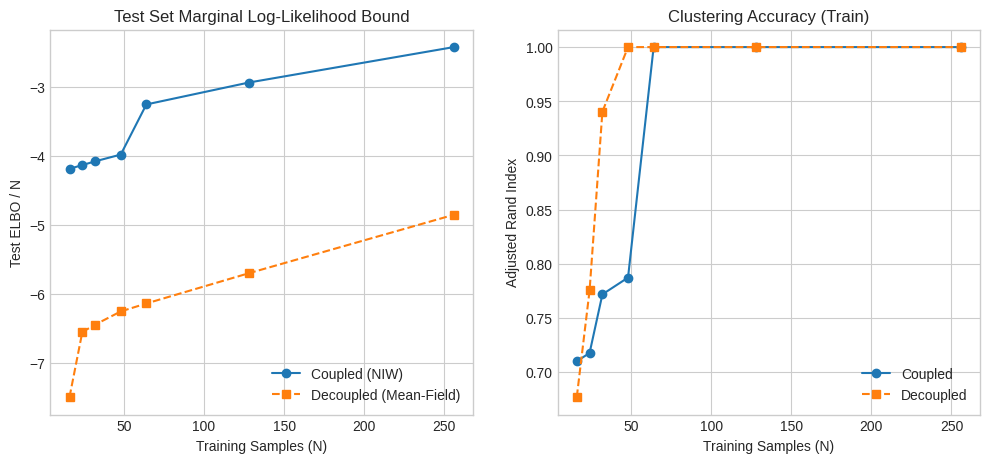

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(data_sizes, results_coupled, 'o-', label='Coupled (NIW)')
plt.plot(data_sizes, results_decoupled, 's--', label='Decoupled (Mean-Field)')
plt.xlabel('Training Samples (N)')
plt.ylabel('Test ELBO / N')
plt.title('Test Set Marginal Log-Likelihood Bound')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_sizes, ari_coupled, 'o-', label='Coupled')
plt.plot(data_sizes, ari_decoupled, 's--', label='Decoupled')
plt.xlabel('Training Samples (N)')
plt.ylabel('Adjusted Rand Index')
plt.title('Clustering Accuracy (Train)')
plt.legend()

plt.show()

### Posterior Uncertainty Visualization

We visualize the 95% confidence ellipses for the cluster means from the posterior trained on a small dataset (N=50). 

*   **Coupled**: The uncertainty in $\mu$ depends on $\Lambda$. The ellipse for $\mu$ should reflect the learned shape of the cluster.
*   **Decoupled**: The uncertainty in $\mu$ is independent. It appears as a generic Gaussian blob (often smaller) around the mean.

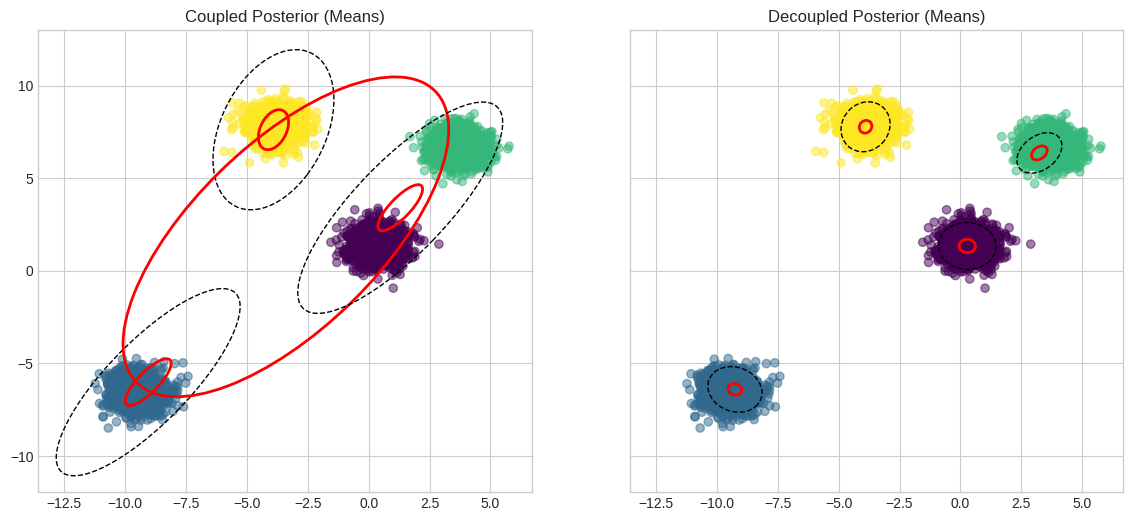

In [8]:
# Train on small data to highlight prior effects
N_vis = 50
X_vis, z_vis = X[:N_vis], z_true[:N_vis]

c_gmm_vis = CoupledBayesianGMM(K_model)
c_gmm_vis.fit(X_vis)

d_gmm_vis = DecoupledBayesianGMM(K_model, D_model)
d_gmm_vis.fit(X_vis)

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot Coupled
ax[0].scatter(X[:, 0], X[:, 1], c=z_true, alpha=0.5, cmap='viridis')
ax[0].set_title("Coupled Posterior (Means)")
for k in range(K_model):
    # Plot Data Ellipse (Expected)
    # E[Lambda^-1] approx (nu-D-1)^-1 W^-1? No, E[Lambda] = nu W. 
    # Expected Covariance = (nu W)^-1
    cov_k = c_gmm_vis.bgmm.covariances_[k]
    mu_k = c_gmm_vis.bgmm.means_[k]
    plot_confidence_ellipse(mu_k, cov_k, ax[0], edgecolor='black', linestyle='--')
    
    # Plot Mean Uncertainty
    # Var(mu) approx (beta * nu * W)^-1
    cov_mu_k = cov_k / c_gmm_vis.bgmm.mean_precision_[k]
    plot_confidence_ellipse(mu_k, cov_mu_k, ax[0], edgecolor='red', linewidth=2)

# Plot Decoupled
ax[1].scatter(X[:, 0], X[:, 1], c=z_true, alpha=0.5, cmap='viridis')
ax[1].set_title("Decoupled Posterior (Means)")
for k in range(K_model):
    # Expected Covariance
    cov_k = np.linalg.inv(d_gmm_vis.nu[k] * d_gmm_vis.W[k])
    plot_confidence_ellipse(d_gmm_vis.m[k], cov_k, ax[1], edgecolor='black', linestyle='--')
    
    # Plot Mean Uncertainty
    # V_k
    plot_confidence_ellipse(d_gmm_vis.m[k], d_gmm_vis.V[k], ax[1], edgecolor='red', linewidth=2)

plt.show()